In [ ]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [26]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [27]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [28]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


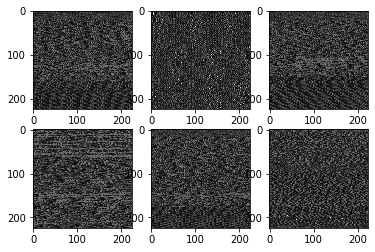

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [29]:
# Using Mobile net V1 as base model for feature extraction 

In [30]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_asm_microsoft_1024.npy')

In [31]:
bytes_features.shape, asm_features.shape

((10868, 1024), (10868, 1024))

In [32]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)

In [33]:
X =  np.array(X)
X.shape

(10868, 2048)

## Classification using MLP(Multi Layer Perceptron)

In [34]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [36]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [37]:
# X_train = X_train // 255.0
# X_test = X_test // 255.0

In [38]:
%%time
clf = MLPClassifier(random_state=31, max_iter=700)

CPU times: user 109 µs, sys: 25 µs, total: 134 µs
Wall time: 154 µs


In [42]:
%%time
clf.fit(X_train,y_train)

CPU times: user 22min 51s, sys: 23min 9s, total: 46min
Wall time: 1min 14s


MLPClassifier(max_iter=700, random_state=31)

In [40]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 92.64


In [41]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 384 ms, sys: 307 ms, total: 691 ms
Wall time: 18.3 ms


In [43]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

93 93 93
CPU times: user 7.19 ms, sys: 0 ns, total: 7.19 ms
Wall time: 6.27 ms


In [44]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       233
         1.0       0.88      0.99      0.93        72
         2.0       1.00      1.00      1.00       623
         3.0       0.95      0.90      0.92       533
         4.0       0.92      0.95      0.93       239
         5.0       0.83      0.88      0.85       310
         6.0       0.14      0.14      0.14         7
         7.0       0.77      0.78      0.78       153
         8.0       0.97      0.96      0.97       113

    accuracy                           0.93      2283
   macro avg       0.82      0.84      0.83      2283
weighted avg       0.93      0.93      0.93      2283



In [45]:
data = [
    {"Class": "Gatak", "Precision": 0.87, "Recall": 0.76, "F1-Score": 0.81, "Support": 261},
    {"Class": "Kelihos_ver1", "Precision": 0.95, "Recall": 0.92, "F1-Score": 0.93, "Support": 85},
    {"Class": "Kelihos_ver3", "Precision": 0.97, "Recall": 0.91, "F1-Score": 0.94, "Support": 682},
    {"Class": "Lollipop", "Precision": 0.90, "Recall": 0.90, "F1-Score": 0.90, "Support": 512},
    {"Class": "Obfuscator.ACY", "Precision": 0.86, "Recall": 0.93, "F1-Score": 0.89, "Support": 228},
    {"Class": "Ramnit", "Precision": 0.94, "Recall": 0.94, "F1-Score": 0.94, "Support": 316},
    {"Class": "Simda", "Precision": 0.22, "Recall": 1.00, "F1-Score": 0.36, "Support": 2},
    {"Class": "Tracur", "Precision": 0.74, "Recall": 0.84, "F1-Score": 0.78, "Support": 134},
    {"Class": "Vundo", "Precision": 0.42, "Recall": 0.70, "F1-Score": 0.52, "Support": 63},
]
precision_values = [item["F1-Score"] for item in data]
for value in precision_values:
    print(value)

0.81
0.93
0.94
0.9
0.89
0.94
0.36
0.78
0.52


In [46]:
# GridSearchCV

In [47]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

CPU times: user 9 µs, sys: 8 µs, total: 17 µs
Wall time: 32.9 µs


In [48]:
%%time
gs = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

CPU times: user 16min 41s, sys: 19min 47s, total: 36min 29s
Wall time: 8min 25s


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=700, random_state=31),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [49]:
print("Best hyperparameters:", gs.best_params_)

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
# to be added in remaining code

print("Accuracy on testing set: {:.3f}".format(gs.score(X_test, y_test)))

In [ ]:
y_pred = gs.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

In [ ]:
list_fams = sorted(label_dict.keys())

In [ ]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_MLP_st.csv')

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_MLP_asm.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_MLP_asm.png', bbox_inches='tight')

plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [ ]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [ ]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [ ]:
FP, FN, TP, TN

In [ ]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

In [ ]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [ ]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

In [ ]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

In [ ]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

In [ ]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

In [ ]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

In [ ]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [ ]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [ ]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_MLP_st.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV1_MLP_st.png", bbox_inches='tight')

plt.show()